# machine learning by graph approach
- database is trained with a graph neural network

In [1]:
import sys
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import datetime

import chainer
from chainer import cuda
chainer.global_config.autotune = True 

sys.path.append("../MIGraph/GraphConv/")
sys.path.append("../MIGraph/Train/")

from GGNN import GGNN
from Config import Config
from AutoParameterScaling import AutoParameterScaling
from GraphNNPredictor import GraphNNPredictor,formatDataset,myConcat

CF=Config()



In [2]:
#load dataset
alldataset= joblib.load("bin/traindataset.bin")

In [3]:
#split dataset using chainer functions
from chainer.iterators import SerialIterator

SPL_RATIO=0.7
miniBatch=32
print("minibatch: ",miniBatch)

split_at = int(len(alldataset) * SPL_RATIO)
trainDataset, testDataset = chainer.datasets.split_dataset_random(alldataset, split_at)

train_iter = SerialIterator(formatDataset(trainDataset), miniBatch)
test_iter = SerialIterator(formatDataset(testDataset),1,False,False)

print("test: ",len(testDataset))
print("train: ",len(trainDataset))

#get labels for prediction
_,_,_,learnLabels=zip(*alldataset)
print("params:", list(set(learnLabels)))

minibatch:  32
test:  94
train:  218
params: ['[s/cm]']


In [4]:
#set up model
from chainer import optimizers
from chainer import training
from chainer.training import extensions


ggnn=GraphNNPredictor()

if CF.GPUMode:
    cuda.get_device(CF.gpu_device).use()
    ggnn.to_gpu(CF.gpu_device)
    print("gpu mode")

#optimizer
optimizer = optimizers.Adam()#alpha=0.0001)
optimizer.setup(ggnn)
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=CF.gpu_device,converter=myConcat)

#trainer (early stopping can be used, but 100 epoch is good)
max_epoch = 100

trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='res')
trainer.extend(extensions.PlotReport(['main/loss','validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.Evaluator(test_iter, ggnn, device=CF.gpu_device))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',  'elapsed_time']))


gpu mode


In [5]:
from chainer import serializers

#training
trainer.run()
serializers.save_npz("bin/mymodel.npz", ggnn)


epoch       main/loss   validation/main/loss  elapsed_time
1           1.54784     1.25627               1.75991       
2           1.1293      0.9221                2.70348       
3           0.862103    0.877315              3.65179       
4           1.06617     0.891258              4.5995        
5           0.89585     0.78104               5.55544       
6           0.898309    0.729307              6.47034       
7           0.807718    0.774989              7.40978       
8           0.902088    0.708076              8.35233       
9           0.90393     0.632227              9.29723       
10          0.68717     0.915525              10.2548       
11          0.765142    0.757562              11.1691       
12          0.778535    0.689089              12.111        
13          0.758355    0.932694              13.058        
14          0.864101    0.661987              14.0429       
15          0.774084    0.555942              14.9786       
16          0.543068    0.

In [6]:
from AnalyzeUtility import AnalyzeUtility

#load scalers and data analyzer
autoscaler=joblib.load("praparingGraphs/output/AutoSC.scaler")
analUtil=AnalyzeUtility(autoscaler,ggnn)

100%|██████████| 7/7 [00:00<00:00, 104.23it/s]R2:  0.8314753243768795
MAE:  0.1671295



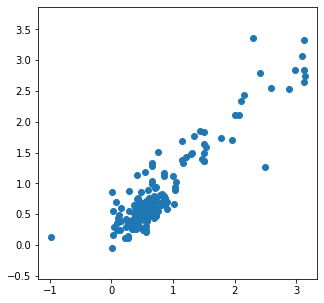

In [7]:
target="[s/cm]"

#train
ggnn.outFingeprint=False
y,t=analUtil.predictByGGNN_batch(formatDataset(trainDataset))
x,y=analUtil.plot(t,y,None,target)



100%|██████████| 3/3 [00:00<00:00, 113.83it/s]R2:  0.7555250089672777
MAE:  0.19707741



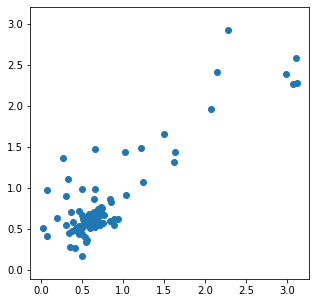

In [8]:
#test
y,t=analUtil.predictByGGNN_batch(formatDataset(testDataset))
x,y=analUtil.plot(t,y,None,target)


100%|██████████| 10/10 [00:00<00:00, 118.12it/s]


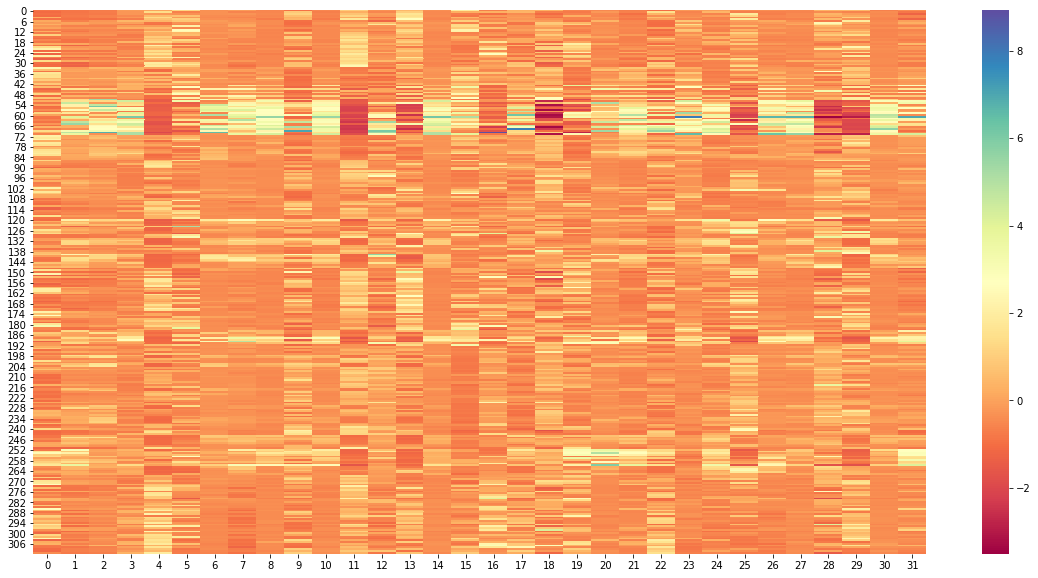

In [9]:
#visualize latent vectors
#check GraphNNPredictor class to see which layer was selected as the internal output

ggnn.outFingeprint=True
trainX,trainY=analUtil.predictByGGNN_batch(formatDataset(alldataset))

sc = StandardScaler()
trainX = sc.fit_transform(trainX)

import seaborn as sns
 
plt.figure(figsize=(20, 10))
sns.heatmap(trainX,cmap="Spectral")